### TPS September 2022
Forecast book sales

#### input
- data spec: 
    - country: Belgium, France, Germany, Italy, Poland, Spain
    - store: KaggleMart, KaggleRama
    - product: 
        - Kaggle Advanced Techniques
        - Kaggle Getting Started
        - Kaggle Recipe Book
        - Kaggle for Kids
- train.csv: row_id,date,country,store,product,num_sold
    - start: 2017-01-01
    - end: 2020-12-31
- test.csv: row_id,date,country,store,product
    - start: 2021-01-01
    - end: 2021-12-31

#### output requirement
- sample_submission.csv: row_id, num_sold
- submission.csv: row_id, num_sold
    - the row_id is same as what in test.csv

#### measurement
- Symmetric mean absolute percentage error (SMAPE): https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error


#### model:
- CatBoost https://catboost.ai/

#### reference:
- https://www.kaggle.com/code/vishnu123/tps-sep-22-eda-lasso-groupkfold-mean-ratios
- https://github.com/nanan4th/Tabular-Playground-Series/blob/main/TPS%20Sep%202022/TPS%20Sep%202022%20v1.0.ipynb
- https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329
- https://catboost.ai/en/docs/concepts/python-reference_catboostregressor
- https://www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-regression



In [1]:
# install needed packages
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install sklearn
# %pip install holidays
# %pip install catboost

In [2]:
# load input data
import numpy as np
import pandas as pd

train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')

train_dataset.info()
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   row_id   17520 non-null  int64 
 1   date     17520 non-null  object
 2   country  17520 non-null  object
 3   store    17520 non-null  object
 4   product  17520 non-null  object
dtypes: int64(1), object(4)
memory usage: 684.5+ KB


In [3]:
# input data pre-processing

# step 1: for time-series problem: transform string date to pd datetime
train_dataset['date'] = pd.to_datetime(train_dataset['date'])
test_dataset['date'] = pd.to_datetime(test_dataset['date'])
print('train_dataset: from ' + str(train_dataset['date'].min()) + ' to ' + str(train_dataset['date'].max()))
print('test_dataset: from ' + str(test_dataset['date'].min()) + ' to ' + str(test_dataset['date'].max()))

# step 2: check if there is any null / duplicated data, if yes drop some
train_dataset = train_dataset.dropna(subset=['date', 'country', 'store', 'product', 'num_sold'])
train_dataset = train_dataset.drop_duplicates(subset=['date', 'country', 'store', 'product', 'num_sold'])
# train_dataset.info()
print('train_dataset duplicated: ', train_dataset.duplicated().sum())
print('train_dataset null: ', train_dataset.isnull().sum().sum())

test_dataset = test_dataset.dropna(subset=['date', 'country', 'store', 'product'])
test_dataset = test_dataset.drop_duplicates(subset=['date', 'country', 'store', 'product'])
print('test_dataset duplicated: ', test_dataset.duplicated().sum())
print('test_dataset null: ', test_dataset.isnull().sum().sum())

# step 3: check unique values: country, store, and product
print('------------- train_dataset ------------- ')
print(train_dataset['country'].value_counts(), '\n')
print(train_dataset['store'].value_counts(), '\n')
print(train_dataset['product'].value_counts(), '\n')

train_dataset: from 2017-01-01 00:00:00 to 2020-12-31 00:00:00
test_dataset: from 2021-01-01 00:00:00 to 2021-12-31 00:00:00
train_dataset duplicated:  0
train_dataset null:  0
test_dataset duplicated:  0
test_dataset null:  0
------------- train_dataset ------------- 
Belgium    11688
France     11688
Germany    11688
Italy      11688
Poland     11688
Spain      11688
Name: country, dtype: int64 

KaggleMart    35064
KaggleRama    35064
Name: store, dtype: int64 

Kaggle Advanced Techniques          17532
Kaggle Getting Started              17532
Kaggle Recipe Book                  17532
Kaggle for Kids: One Smart Goose    17532
Name: product, dtype: int64 



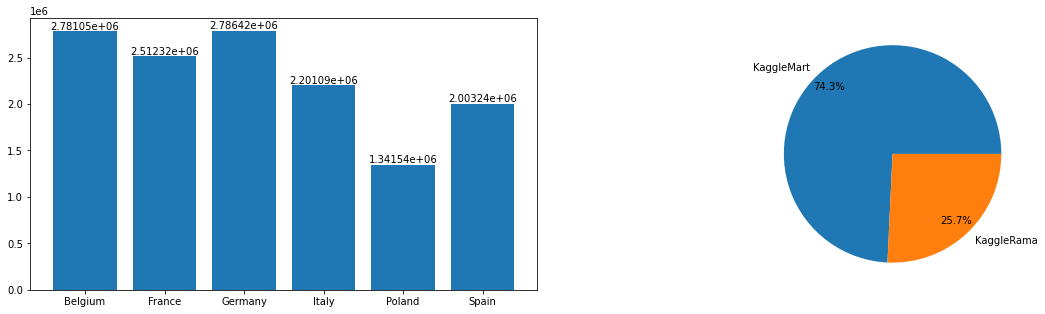

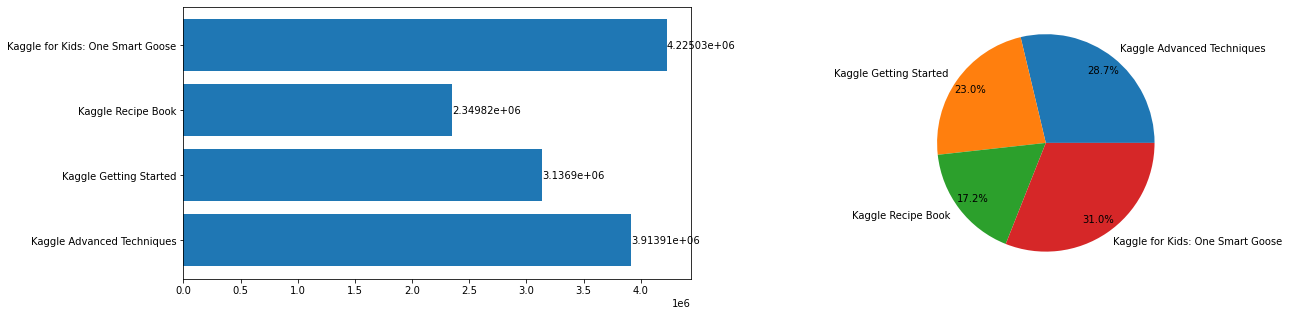

In [4]:
# Exploratory Data Analysis (EDA) and outliers detection
import matplotlib.pyplot as plt
import seaborn as sns

# 1, total num of sales pie chart by country / store / product(book)
fig1 = plt.figure(figsize=(20,5))
fig1.set_facecolor('white')

sold_by_country = train_dataset.groupby(['country'])['num_sold'].sum()
sold_by_store = train_dataset.groupby(['store'])['num_sold'].sum()
sold_by_product = train_dataset.groupby(['product'])['num_sold'].sum()

# by country
ax1 = fig1.add_subplot(1, 2, 1)
bars1 = ax1.bar(sold_by_country.keys(), sold_by_country.values)
ax1.bar_label(bars1)

# by store
ax2 = fig1.add_subplot(1, 2, 2)
pie2 = ax2.pie(sold_by_store, labels=sold_by_store.keys(),  autopct='%1.1f%%', pctdistance=0.85)

# by product
fig2 = plt.figure(figsize=(20,5))
fig2.set_facecolor('white')
ax3 = fig2.add_subplot(1, 2, 1)
bars3 = ax3.barh(sold_by_product.keys(), sold_by_product)
ax3.bar_label(bars3)
ax4 = fig2.add_subplot(1, 2, 2)
pie4 = ax4.pie(sold_by_product, labels=sold_by_product.keys(),  autopct='%1.1f%%', pctdistance=0.85)


#### Insights
- Germany and Belgium have the highest total num of book sold, Poland has the lowest
- Kaggle Advanced Techniques has the highest total num of book sold, Kaggle Recipe Book has the lowest
- KaggleMart total num of book sold is around 3 times of KaggleRama

<AxesSubplot:xlabel='date', ylabel='num_sold'>

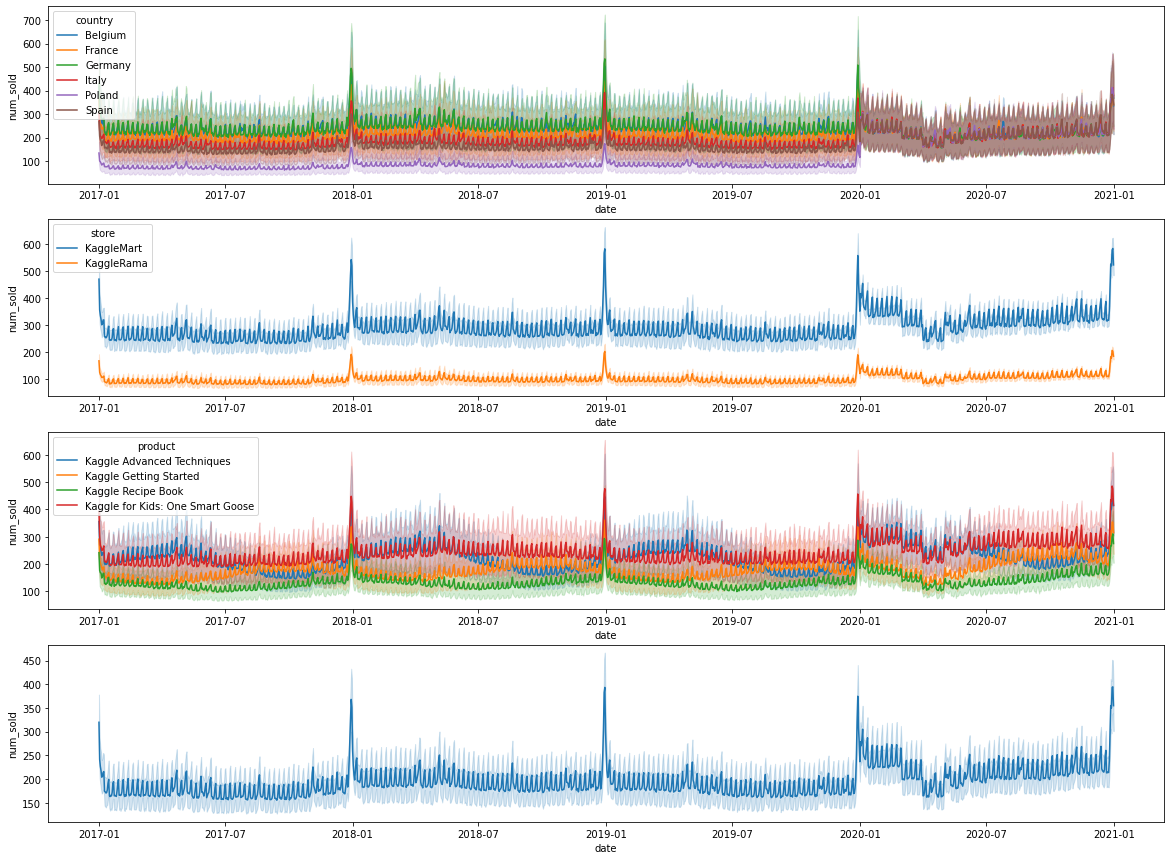

In [5]:
# 2, time series num of sales by country / store /product(book)
fig3 = plt.figure(figsize=(20,15))
fig3.set_facecolor('white')

# by country
ax5 = fig3.add_subplot(4, 1, 1)
sns.lineplot(data=train_dataset, x='date', y='num_sold', hue='country')

# by store
ax6 = fig3.add_subplot(4, 1, 2)
sns.lineplot(data=train_dataset, x='date', y='num_sold', hue='store')

# by product
ax7 = fig3.add_subplot(4, 1, 3)
sns.lineplot(data=train_dataset, x='date', y='num_sold', hue='product')

# total
ax8 = fig3.add_subplot(4, 1, 4)
sns.lineplot(data=train_dataset, x='date', y='num_sold')

#### Insights
- peak in Dec to Jan
- drop in earlier 2020 due to covid-19 pandemic: to ignore data from 2020-02-01 to 2020-06-01
- increasing in 2020 than previous years

In [6]:
# Modeling - data further processing
from sklearn.preprocessing import LabelEncoder
import holidays

# drop outliers data: Feb 2020 to June 2020 due to covid-19 
train_dataset = train_dataset.loc[~((train_dataset["date"] >= "2020-02-01") & (train_dataset["date"] < "2020-06-01"))]

def data_process(df):   
    # 1, add features: is_country_holiday, year, month, day, weekday, dayofyear, 
    def encode_holiday(df):
        years_list = [2017, 2018, 2019, 2020, 2021]
        df.loc[df['country'] == 'Belgium', 'holiday_name'] = df['date'].map(holidays.CountryHoliday('BE', years=years_list))
        df.loc[df['country'] == 'France', 'holiday_name'] = df['date'].map(holidays.CountryHoliday('FR', years=years_list))
        df.loc[df['country'] == 'Germany', 'holiday_name'] = df['date'].map(holidays.CountryHoliday('DE', years=years_list))
        df.loc[df['country'] == 'Italy', 'holiday_name'] = df['date'].map(holidays.CountryHoliday('IT', years=years_list))
        df.loc[df['country'] == 'Poland', 'holiday_name'] = df['date'].map(holidays.CountryHoliday('PL', years=years_list))
        df.loc[df['country'] == 'Spain', 'holiday_name'] = df['date'].map(holidays.CountryHoliday('ES', years=years_list))
        df['is_country_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    encode_holiday(df)
    df['year'], df['month'] = df['date'].dt.year, df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['dayofyear'] = df['date'].dt.dayofyear

    # 2, drop no longer need columns: row_id, date, holiday_name
    df = df.drop(['holiday_name', 'row_id', 'date'], axis=1)  # axis=1 drop columns, axis=0 drop rows

    # 3, encode label: country, store, product
    label_encoder = LabelEncoder()
    for col in ['country', 'store', 'product']:
        df[col] = label_encoder.fit_transform(df[col])

    return df

train_dataset = data_process(train_dataset)
test_dataset = data_process(test_dataset)
print(train_dataset.head())
print(test_dataset.head())

   country  store  product  num_sold  is_country_holiday  year  month  day  \
0        0      0        0       663                   1  2017      1    1   
1        0      0        1       615                   1  2017      1    1   
2        0      0        2       480                   1  2017      1    1   
3        0      0        3       710                   1  2017      1    1   
4        0      1        0       240                   1  2017      1    1   

   weekday  dayofyear  
0        6          1  
1        6          1  
2        6          1  
3        6          1  
4        6          1  
   country  store  product  is_country_holiday  year  month  day  weekday  \
0        0      0        0                   1  2021      1    1        4   
1        0      0        1                   1  2021      1    1        4   
2        0      0        2                   1  2021      1    1        4   
3        0      0        3                   1  2021      1    1        4   
4 

In [ ]:
# Modeling - CatBoosterRegressor hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
import catboost as cb

train_dataset_x = train_dataset.drop('num_sold', axis=1)
train_dataset_y = train_dataset['num_sold']

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

cbr_model = cb.CatBoostRegressor(eval_metric=cb.metrics.SMAPE())  # loss_function='RMSE' by default for CatBoostRegressor
cbr_params = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1, 0.3, 0.5],
    'depth': [5, 10, 15],
    'l2_leaf_reg': [0.2, 0.5],
}
grid = GridSearchCV(n_jobs=-1,
            estimator=cbr_model, param_grid=cbr_params, scoring=make_scorer(smape, greater_is_better=False))
grid.fit(train_dataset_x, train_dataset_y)

In [8]:
print('best params for CatBoosterRegressor', grid.best_params_)
# best params for CatBoosterRegressor {'depth': 10, 'iterations': 200, 'l2_leaf_reg': 0.2, 'learning_rate': 0.1}

best params for CatBoosterRegressor {'depth': 10, 'iterations': 200, 'l2_leaf_reg': 0.2, 'learning_rate': 0.1}


In [ ]:
# Modeling - model fitting

# create model using the best params from the tuning result
best_cbr_model = cb.CatBoostRegressor(eval_metric=cb.metrics.SMAPE(), 
    iterations=grid.best_params_['iterations'],
    learning_rate=grid.best_params_['learning_rate'],
    depth=grid.best_params_['depth'],
    l2_leaf_reg=grid.best_params_['l2_leaf_reg'],
) 

# fitting method 1: manual split dataset and fit model
# step 1: split the original train_dataset to a 80% training set and 20% cross validation testing set 
# X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(train_dataset_x, train_dataset_y, test_size = 0.2, random_state=0)
# train_pool = cb.Pool(X_train_cv, y_train_cv) # 80% of the original given train.csv
# # step 2: fit the modelusing 80% data, with 20% data as cross validation eval_set
# best_cbr_model.fit(train_pool, eval_set=(X_test_cv, y_test_cv))
# # step 3: predicting
# y_test_pred = best_cbr_model.predict(test_dataset)


# fitting method 2: use cross_validate func on the whole input train_dataset (no need to do manual split the data to fit)
# step 1: cross_validate
pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', grid.best_estimator_)])
cv_results = cross_validate(pipeline, train_dataset_x, train_dataset_y, cv=5, 
        scoring=make_scorer(smape, greater_is_better=False), 
        return_train_score=True, 
        return_estimator=True, 
        n_jobs=-1
)
# step 2: predicting
y_test_pred = np.zeros(test_dataset.shape[0])
for estimator in cv_results['estimator']:
    y_test_pred += estimator.predict(test_dataset)
y_test_pred /= len(cv_results['estimator'])

In [10]:
# generate submission.csv
sample_submission = pd.read_csv('sample_submission.csv')
submission = pd.DataFrame({
    'row_id': sample_submission['row_id'],
    'num_sold': y_test_pred
})
submission.to_csv('submission.csv', index=False)